In [69]:
import torch
import torch.nn as nn
# import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tqdm

##### Source: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/recurrent-neural-networks/time-series/Simple_RNN.ipynb

### Data Visualization

##### Random Data Generation

In [50]:
# torch.reshape?

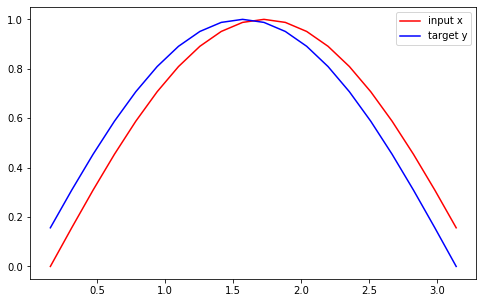

In [49]:
plt.figure(figsize=(8, 5))

seq_length = 20

time_steps = torch.linspace(start=0, end=np.pi, steps=seq_length+1)
data = torch.sin(time_steps)

# add additional layer
data = torch.reshape(data, (seq_length+1, 1))

x = data[:-1]
y = data[1:]

plt.plot(time_steps[1:], x, 'r', label="input x")
plt.plot(time_steps[1:], y, 'b', label="target y")
plt.legend()
plt.show()

### RNN Model

In [103]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

### Test for input shape matching

In [108]:
model = RNN(input_size=1, hidden_dim=10, n_layers=2, output_size=10)
time_steps = torch.linspace(start=0, end=np.pi, steps=seq_length)
data = torch.sin(time_steps)
data = torch.reshape(data, (seq_length, 1))
test_input = torch.Tensor(data).unsqueeze(0)
out, hidden = model(test_input, None)
print(out.size(), hidden.size())

torch.Size([20, 10]) torch.Size([2, 1, 10])


### Model and Hyper-params

In [109]:
#### CConfiguration

# model hyper params
input_size = 1
output_size = 1
hidden_dim  = 32
num_layers = 1

# training hp
lr = 1e-3
steps = 100

In [110]:
rnn = RNN(input_size=input_size, hidden_dim=hidden_dim, n_layers=num_layers, output_size=output_size)

In [111]:
### Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Training Loop

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Loss:  0.4533173441886902


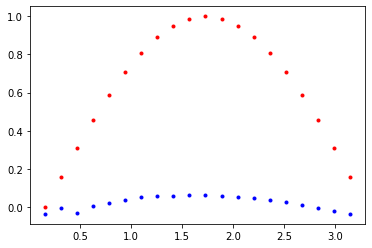

Epoch:   1%|          | 1/100 [00:00<00:09,  9.94it/s]

Loss:  0.4520559310913086


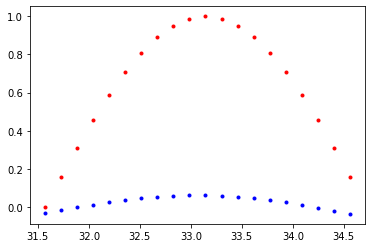

Epoch:  12%|█▏        | 12/100 [00:00<00:06, 13.67it/s]

Loss:  0.4520559310913086


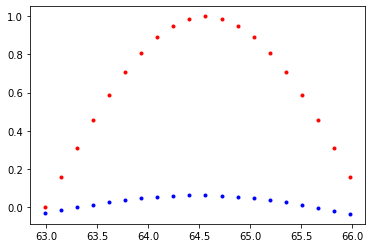

Epoch:  21%|██        | 21/100 [00:00<00:04, 18.30it/s]

Loss:  0.4520559310913086


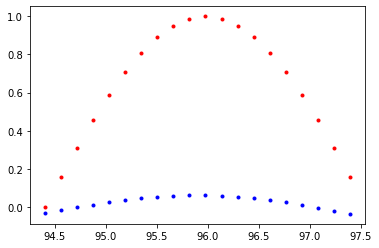

Epoch:  31%|███       | 31/100 [00:00<00:02, 24.18it/s]

Loss:  0.4520559310913086


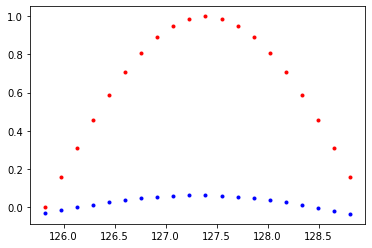

Epoch:  44%|████▍     | 44/100 [00:00<00:01, 31.97it/s]

Loss:  0.4520559310913086


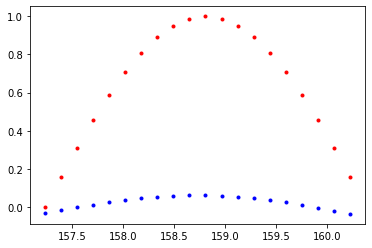

Epoch:  53%|█████▎    | 53/100 [00:00<00:01, 39.58it/s]

Loss:  0.4520559310913086


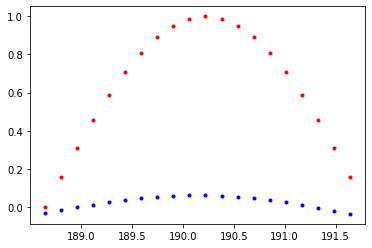

Epoch:  64%|██████▍   | 64/100 [00:00<00:00, 48.94it/s]

Loss:  0.4520559310913086


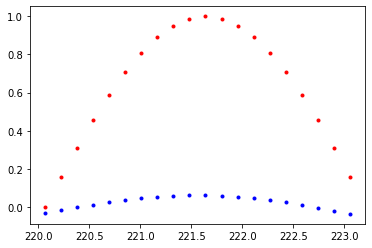

Epoch:  75%|███████▌  | 75/100 [00:00<00:00, 58.64it/s]

Loss:  0.4520559310913086


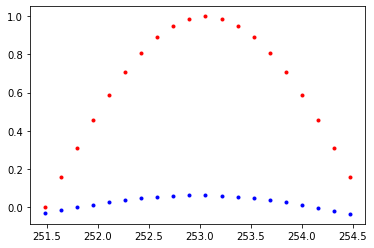

Epoch:  85%|████████▌ | 85/100 [00:00<00:00, 66.77it/s]

Loss:  0.4520559310913086


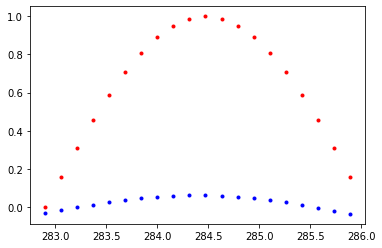

Epoch: 100%|██████████| 100/100 [00:13<00:00, 76.88it/s]

In [112]:
progress = tqdm.tqdm(total=steps, desc="Epoch", position=0)
hidden = None

for batch_i, step  in enumerate(range(steps)):
            # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%10 == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
        
        progress.update(1)
 

## More Time Series Prediction

#### Dataset: https://www.kaggle.com/rakannimer/air-passengers
#### Source https://github.com/Ferdib-Al-Islam/lstm-time-series-prediction-pytorch/blob/master/lstm-time-series-pytorch.ipynb

In [144]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable

In [114]:
# read the data
data = pd.read_csv("./data/datasets_1057_1913_AirPassengers.csv")

In [115]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


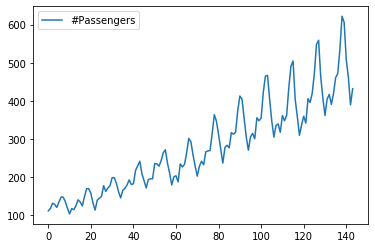

In [118]:
data.plot()

##### Sequence Clipping

In [145]:

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(data)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [146]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [147]:

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.71171
Epoch: 100, loss: 0.01051
Epoch: 200, loss: 0.00502
Epoch: 300, loss: 0.00329
Epoch: 400, loss: 0.00315
Epoch: 500, loss: 0.00304
Epoch: 600, loss: 0.00292
Epoch: 700, loss: 0.00280
Epoch: 800, loss: 0.00268
Epoch: 900, loss: 0.00256
Epoch: 1000, loss: 0.00245
Epoch: 1100, loss: 0.00234
Epoch: 1200, loss: 0.00225
Epoch: 1300, loss: 0.00216
Epoch: 1400, loss: 0.00209
Epoch: 1500, loss: 0.00203
Epoch: 1600, loss: 0.00198
Epoch: 1700, loss: 0.00193
Epoch: 1800, loss: 0.00190
Epoch: 1900, loss: 0.00187


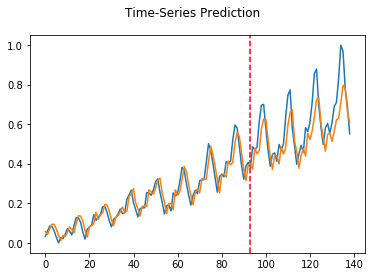

In [148]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()